In [1]:
import numpy as np

from astropy.io import fits
from astropy import wcs

from jwst import datamodels
from jwst.assign_wcs import nirspec
print(datamodels.__file__)

/internal/1/astropy/jwst/jwst/datamodels/__init__.py


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['image.origin'] = 'lower'

In [3]:
#im = datamodels.ImageModel('ALLSLITS_assign_wcs.fits')
im = datamodels.open("final_output_caldet1_NRS2_assign_wcs.fits")

In [4]:
# Compute percentage of pixels above certain threshold
def compute_percentage(values, threshold):
    values = values[~np.isnan(values)]
    n_total = values.size
    
    thresh = [threshold, 3*threshold, 5*threshold]
    res = []
    for i in thresh:
        n = np.logical_or(values > i, values< -i).nonzero()[0].size
        res.append((n / n_total) * 100)
    return res

### Compare in full frame coordinates - wcs.get_transform('sca', 'world')

In [5]:
map_slit_names = [(3, 'Trace_MOS_1_105_062_V84600010001P0000000002101_39547_JLAB88.fits'), 
                  (1, 'Trace_MOS_2_020_157_V84600010001P0000000002101_39547_JLAB88.fits')]

trace:   Trace_MOS_1_105_062_V84600010001P0000000002101_39547_JLAB88.fits
trace:   Trace_MOS_2_020_157_V84600010001P0000000002101_39547_JLAB88.fits


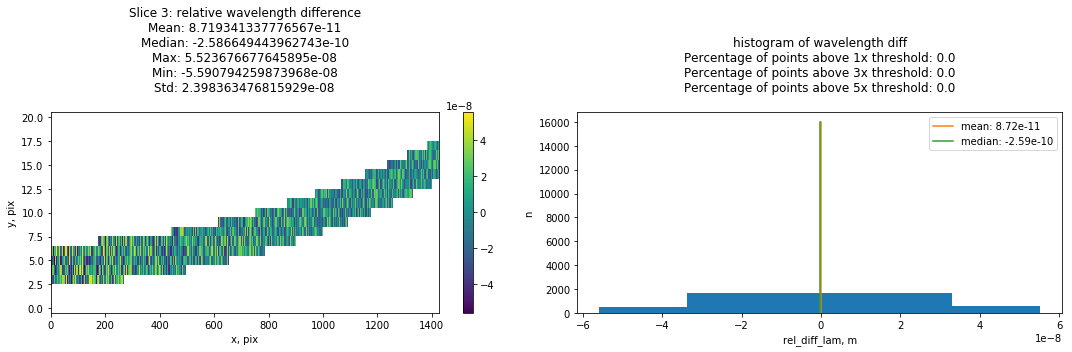

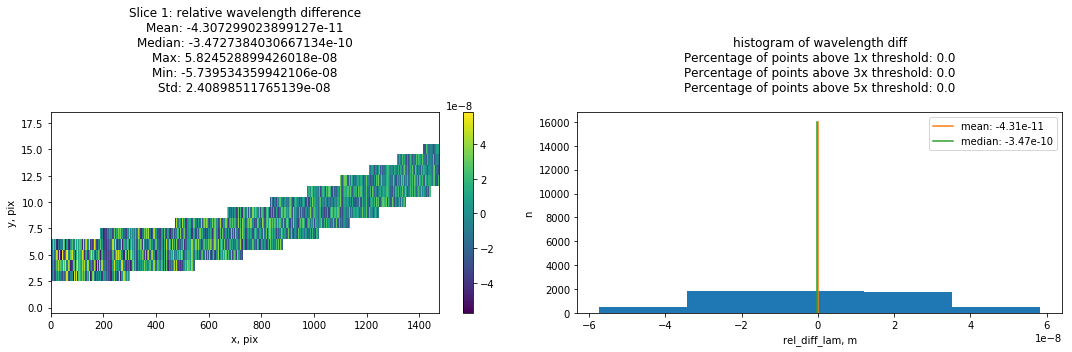

In [6]:
for item in map_slit_names:
    slice_id, trace = item
    tr = fits.open(trace)
    print("trace:  ", trace)
    #tr.info()
    lam1 = tr['LAMBDA2'].data
    slit1 = tr['SLITY2'].data
    pyw = wcs.WCS(tr['LAMBDA2'].header)
    tr.close()

    # Create x, y indices using the Trace WCS
    y, x =np.mgrid[:lam1.shape[0], : lam1.shape[1]]
    x1, y1 = pyw.all_pix2world(x, y, 0)

    # Get the WCS for this particular slice
    wcs_slice = nirspec.nrs_wcs_set_input(im, slice_id)

    # Get the transfrom from SCA (in full frame coordinates) to world
    sca2world = wcs_slice.get_transform('sca', 'world')
    # Compute ra, dec and lambda
    ra, dec, lam = sca2world(x1-1, y1-1)
    #ra, dec, lam = wcs_slice(x1-1, y1-1, with_bounding_box=False)
    lam *= 10**-6

    # Compute indices for slit-y between -.5 and .5
    in_slit = np.logical_and(slit1<.5, slit1>-.5)
    lam[~in_slit] = np.nan
    nanind = np.isnan(lam)
    notnan = ~nanind
    # Set lam values outside the slit to NaN
    lam1[nanind] = np.nan

    # Compute the difference in wavelength
    rel_diff_lam = (lam1 - lam) / lam1

    # Compute statistics for notnan indices
    mean = np.mean(rel_diff_lam[notnan])
    median = np.median(rel_diff_lam[notnan])
    dmax = np.max(rel_diff_lam[notnan])
    dmin = np.min(rel_diff_lam[notnan])
    dstd = np.std(rel_diff_lam[notnan])
    percentage_results = compute_percentage(rel_diff_lam, 1e-7)

    title1 = "Slice {}: relative wavelength difference\n".format(slice_id)
    title1 += "Mean: {}\n".format(mean)
    title1 += "Median: {}\n".format(median)
    title1 += "Max: {}\n".format(dmax)
    title1 += "Min: {}\n".format(dmin)
    title1 += "Std: {}\n".format(dstd)

    title2 = "histogram of wavelength diff\n"
    title2 += "Percentage of points above 1x threshold: {}\n".format(percentage_results[0])
    title2 += "Percentage of points above 3x threshold: {}\n".format(percentage_results[1])
    title2 += "Percentage of points above 5x threshold: {}\n".format(percentage_results[2])

    fig = plt.figure(figsize=(15, 5))
    ax1 = plt.subplot(1,2,1)
    i1 = ax1.imshow(rel_diff_lam, aspect='auto')
    plt.title(title1)
    plt.colorbar(i1, ax=ax1 )
    plt.xlabel('x, pix')
    plt.ylabel('y, pix')
    ax2 = plt.subplot(1,2,2)
    i2 = plt.hist(rel_diff_lam[~np.isnan(rel_diff_lam)].flatten(), bins=5)
    ax2.plot([mean]*2, [0,16000], label="mean: {:3.2e}".format(mean))
    ax2.plot([median]*2, [0,16000], label="median: {:3.2e}".format(median))
    ax2.legend()
    plt.title(title2)
    plt.xlabel('rel_diff_lam, m')
    plt.ylabel('n')
    fig.tight_layout()

### Comparison using the full WCS.

The pipeline appends one final transform for NRS2 detector. It assumes the instrument model for NRS2 ends with coordinates on the FPA where the origin (0, 0) is in the upper right corner of the detector with positive direction in x and y going to the left and downwards. To The final transform appended to the WCS is to change the final coordinates on the detector to be in a frame with origin in the lower left corner. So the output of the instrument model is ofsfet and rotated, effectively -1 * (x-2047) and -1 * ( y -2017). In testing against the ESa traces it appears this is not necessary. The test above uses the transform from "SCA" to "world" which is the instrument model. The test that follows uses the instrument model and the transforms described here. This gives no match at all against ESA coordinates.


In [12]:
# Compute ra, dec and lambda
ra, dec, lam = wcs_slice(x2-1, y2-1, with_bounding_box=False)
lam *= 10**-6

# Compute indices for slit-y between -.5 and .5
in_slit = np.logical_and(slit1<.5, slit1>-.5)
lam[~in_slit] = np.nan
nanind = np.isnan(lam)
notnan = ~nanind
# Set lam values outside the slit to NaN
lam1[nanind] = np.nan

# Compute the difference in wavelength
rel_diff_lam = (lam1 - lam) / lam1

# Compute statistics for notnan indices
mean = np.mean(rel_diff_lam[notnan])
median = np.median(rel_diff_lam[notnan])
dmax = np.max(rel_diff_lam[notnan])
dmin = np.min(rel_diff_lam[notnan])
dstd = np.std(rel_diff_lam[notnan])
percentage_results = compute_percentage(rel_diff_lam, 1e-7)

title1 = "Slice {}: relative wavelength difference\n".format(slice_id)
title1 += "Mean: {}\n".format(mean)
title1 += "Median: {}\n".format(median)
title1 += "Max: {}\n".format(dmax)
title1 += "Min: {}\n".format(dmin)
title1 += "Std: {}\n".format(dstd)

title2 = "histogram of wavelength diff\n"
title2 += "Percentage of points above 1x threshold: {}\n".format(percentage_results[0])
title2 += "Percentage of points above 3x threshold: {}\n".format(percentage_results[1])
title2 += "Percentage of points above 5x threshold: {}\n".format(percentage_results[2])

fig = plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1,2,1)
i1 = ax1.imshow(rel_diff_lam, aspect='auto')
plt.title(title1)
plt.colorbar(i1, ax=ax1 )
plt.xlabel('x, pix')
plt.ylabel('y, pix')
ax2 = plt.subplot(1,2,2)
i2 = plt.hist(rel_diff_lam[~np.isnan(rel_diff_lam)].flatten(), bins=5)
ax2.plot([mean]*2, [0,16000], label="mean: {:3.2e}".format(mean))
ax2.plot([median]*2, [0,16000], label="median: {:3.2e}".format(median))
ax2.legend()
plt.title(title2)
plt.xlabel('rel_diff_lam, m')
plt.ylabel('n')
fig.tight_layout()

ValueError: zero-size array to reduction operation maximum which has no identity